In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/luna16/sampleSubmission.csv
/kaggle/input/luna16/annotations.csv
/kaggle/input/luna16/candidates.csv
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.311236942972970815890902714604.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.212346425055214308006918165305.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.281967919138248195763602360723.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.707218743153927597786179232739.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.217697417596902141600884006982.mhd
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.283569726884265181140892667131.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.192256506776434538421891524301.raw
/kaggle/input/luna16/subset2/subset2/1.3.6.1.4.1.14519.5.2.1.6279.6001.113586291551175790743673929831.raw
/kaggle/input/luna16/subset2/subset2/

In [4]:
import copy
import time
from tqdm.notebook import tqdm
from collections import namedtuple





In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
import os
import glob
import SimpleITK as sitk
from PIL import Image
from imageio import imread
%matplotlib inline
from PIL import Image
from imageio import imread
from joblib import Parallel, delayed
from collections import namedtuple

In [6]:
df_annotations = pd.read_csv('/kaggle/input/luna16/annotations.csv')
df_annotations.head()

,seriesuid,coordX,coordY,coordZ,diameter_mm
0,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,-128.699421,-175.319272,-298.387506,5.651471
1,1.3.6.1.4.1.14519.5.2.1.6279.6001.100225287222...,103.783651,-211.925149,-227.121250,4.224708
2,1.3.6.1.4.1.14519.5.2.1.6279.6001.100398138793...,69.639017,-140.944586,876.374496,5.786348
3,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,-24.013824,192.102405,-391.081276,8.143262
4,1.3.6.1.4.1.14519.5.2.1.6279.6001.100621383016...,2.441547,172.464881,-405.493732,18.545150


In [7]:
df_candidates = pd.read_csv('/kaggle/input/luna16/candidates_V2/candidates_V2.csv')
df_candidates = df_candidates.sort_values(["class"],ascending=False)
df_candidates = df_candidates.head(3000)

In [8]:
print(f'Total annotations: {df_annotations.shape[0]}, Unique CT scans: {len(df_annotations.seriesuid.unique())}')
print(f'Total candidates: {df_candidates.shape[0]}, Unique CT scans: {len(df_candidates.seriesuid.unique())}')

Total annotations: 1186, Unique CT scans: 601
Total candidates: 3000, Unique CT scans: 603


In [9]:

diameters = {}
for _, row in df_annotations.iterrows():
    center_xyz = (row.coordX, row.coordY, row.coordZ)
    diameters.setdefault(row.seriesuid, []).append(
        (center_xyz, row.diameter_mm)
    )



In [10]:
%%time
CandidateInfoTuple = namedtuple(
    'CandidateInfoTuple',
    ['is_nodule', 'diameter_mm', 'series_uid', 'center_xyz']
)
candidates = []

for _, row in df_candidates.iterrows():
    
    candidate_center_xyz = (row.coordX, row.coordY, row.coordZ)
    candidate_diameter = 0.0
    for annotation in diameters.get(row.seriesuid, []):
        annotation_center_xyz, annotation_diameter = annotation
        for i in range(3):
            delta = abs(candidate_center_xyz[i] - annotation_center_xyz[i])
            if delta > annotation_diameter / 4:
                    break
        else:
            candidate_diameter = annotation_diameter
            break
    candidates.append(CandidateInfoTuple(
        bool(row['class']),
        candidate_diameter,
        row.seriesuid,
        candidate_center_xyz
    ))

CPU times: user 407 ms, sys: 0 ns, total: 407 ms
Wall time: 406 ms


In [11]:
candidates.sort(reverse=True)

In [12]:
with open('/kaggle/input/luna16missingcandidates/missing.txt', 'r') as f:
    missing_uids = {uid.split('\n')[0] for uid in f}
    
len(missing_uids)

443

In [13]:
candidates_clean = list(filter(lambda x: x.series_uid not in missing_uids, candidates))

print(f'All candidates in dataset: {len(candidates)}')
print(f'Candidates with CT scan  : {len(candidates_clean)}')
candidate = candidates_clean[0]

candidate

All candidates in dataset: 3000
Candidates with CT scan  : 1662


CandidateInfoTuple(is_nodule=True, diameter_mm=32.27003025, series_uid='1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886', center_xyz=(66.58022805, 82.56931698, -110.5421104))

In [14]:
# Look for the file `<series_uid>.mhd` inside the `subset` folders
filepaths = glob.glob(f'/kaggle/input/luna16/subset*/*/{candidate.series_uid}.mhd')

# We removed all candidates that don't have corresponding CT scan files
# This line is another fail-safe to know when a CT scan doesn't exist
assert len(filepaths) != 0, f'CT scan with seriesuid {candidate.series_uid} not found!'

filepaths

['/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd']

In [15]:
mhd_file_path = filepaths[0]

mhd_file_path

'/kaggle/input/luna16/subset1/subset1/1.3.6.1.4.1.14519.5.2.1.6279.6001.287966244644280690737019247886.mhd'

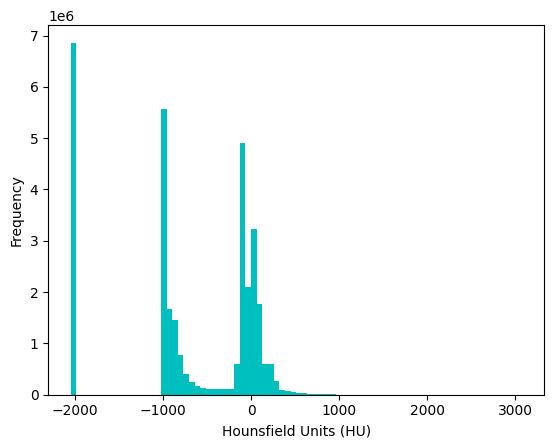

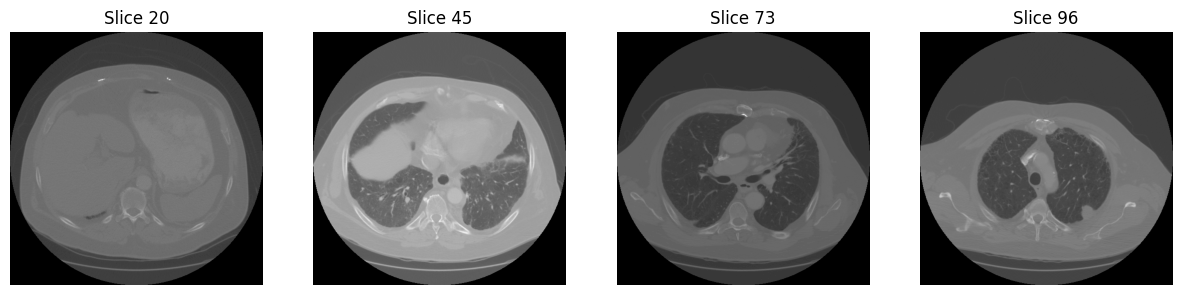

In [16]:
mhd_file = sitk.ReadImage(mhd_file_path)
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
plt.hist(ct_scan.flatten(), bins=80, color='c')
plt.xlabel("Hounsfield Units (HU)")
plt.ylabel("Frequency")
plt.show()

# Show some slice in the middle
#plt.imshow(ct_scan[35],cmap = plt.cm.gray)
#plt.show()
scan = [20, 45, 73, 96]  

# Display selected slices
num_slices = len(scan)
rows, cols = 1, num_slices

fig, axs = plt.subplots(rows, cols, figsize=(15, 5))

for i in range(num_slices):
    slice_index = scan[i]
    axs[i].imshow(ct_scan[slice_index], cmap=plt.cm.gray)
    axs[i].set_title(f'Slice {slice_index}')
    axs[i].axis('off')

plt.show()

In [17]:
mhd_file = sitk.ReadImage(mhd_file_path)
ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
ct_scan.clip(-1000, 1000, ct_scan)

array([[[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.]],

       [[-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        [-1000., -1000., -1000., ..., -1000., -1000., -1000.],
        ...,
        [-10

In [18]:
origin_xyz = mhd_file.GetOrigin()
voxel_size_xyz = mhd_file.GetSpacing()
direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
origin_xyz_np = np.array(origin_xyz)
voxel_size_xyz_np = np.array(voxel_size_xyz)

In [19]:
# Convert the coordinates of the center of the candidate
# from the patient coordinate system to column, row, index
cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np

# Since we'll be using column, row and index values to index into arrays,
# we round them to the nearest integer.
cri = np.round(cri)

# Going forward, we'll need the scan to be in the order index, row, column
irc = (int(cri[2]), int(cri[1]), int(cri[0]))

In [20]:
dims_irc = (10, 18, 18)
slice_list = []

for axis, center_val in enumerate(irc):
    
    # Get start and end index for the dimension so that the
    # nodule center is at the center of the 3d array we extract
    start_index = int(round(center_val - dims_irc[axis]/2))
    end_index = int(start_index + dims_irc[axis])

    # Adjust the indexes if the start_index is out of the CT scan array
    if start_index < 0:
        start_index = 0
        end_index = int(dims_irc[axis])
    
    # Do the same check for the end_index
    if end_index > ct_scan.shape[axis]:
        end_index = ct_scan.shape[axis]
        start_index = int(ct_scan.shape[axis] - dims_irc[axis])
        
    slice_list.append(slice(start_index, end_index))
    
tuple(slice_list)
ct_scan_chunk = ct_scan[tuple(slice_list)]
ct_scan_chunk.shape

(10, 18, 18)

In [21]:
candidate.is_nodule
torch.tensor([
    not candidate.is_nodule,
    candidate.is_nodule,
], dtype=torch.float32)

tensor([0., 1.])

In [22]:
# Create a tensor from the NumPy array of the CT scan chunk
ct_scan_chunk_tensor = torch.from_numpy(ct_scan_chunk)

# convert it to a tensor of float32
ct_scan_chunk_tensor = ct_scan_chunk_tensor.to(torch.float32)
    
# Add an extra dimension to represent a single channel in the 3d image
ct_scan_chunk_tensor = ct_scan_chunk_tensor.unsqueeze(0)

ct_scan_chunk_tensor.shape
torch.tensor([
    not candidate.is_nodule,
    candidate.is_nodule,
], dtype=torch.long)

tensor([0, 1])

In [26]:
import gzip

from cassandra.cqltypes import BytesType
from diskcache import FanoutCache, Disk, core
from diskcache.core import io, MODE_BINARY
from io import BytesIO

class GzipDisk(Disk):
    def store(self, value, read, key=None):

        # pylint: disable=unidiomatic-typecheck
        if type(value) is BytesType:
            if read:
                value = value.read()
                read = False

            str_io = BytesIO()
            gz_file = gzip.GzipFile(mode='wb', compresslevel=1, fileobj=str_io)

            for offset in range(0, len(value), 2**30):
                gz_file.write(value[offset:offset+2**30])
            gz_file.close()

            value = str_io.getvalue()

        return super(GzipDisk, self).store(value, read)


    def fetch(self, mode, filename, value, read):
        value = super(GzipDisk, self).fetch(mode, filename, value, read)

        if mode == MODE_BINARY:
            str_io = BytesIO(value)
            gz_file = gzip.GzipFile(mode='rb', fileobj=str_io)
            read_csio = BytesIO()

            while True:
                uncompressed_data = gz_file.read(2**30)
                if uncompressed_data:
                    read_csio.write(uncompressed_data)
                else:
                    break

            value = read_csio.getvalue()

        return value

def getCache(scope_str):
    return FanoutCache('data-unversioned/cache/' + scope_str,
                       disk=GzipDisk,
                       shards=64,
                       timeout=1,
                       size_limit=3e11,
                       )

raw_cache = getCache('ct_scan_raw')

@raw_cache.memoize(typed=True)
def getCtScanChunk(series_uid, center_xyz, dims_irc):

        filepaths = glob.glob(f'/kaggle/input/luna16/subset*/*/{series_uid}.mhd')
        assert len(filepaths) != 0, f'CT scan with seriesuid {series_uid} not found!'
        mhd_file_path = filepaths[0]
        
        mhd_file = sitk.ReadImage(mhd_file_path)
        ct_scan = np.array(sitk.GetArrayFromImage(mhd_file), dtype=np.float32)
        ct_scan.clip(-1000, 1000, ct_scan)
        
        origin_xyz = mhd_file.GetOrigin()
        voxel_size_xyz = mhd_file.GetSpacing()
        direction_matrix = np.array(mhd_file.GetDirection()).reshape(3, 3)
        
        origin_xyz_np = np.array(origin_xyz)
        voxel_size_xyz_np = np.array(voxel_size_xyz)
        
        cri = ((center_xyz - origin_xyz_np) @ np.linalg.inv(direction_matrix)) / voxel_size_xyz_np
        cri = np.round(cri)
        irc = (int(cri[2]), int(cri[1]), int(cri[0]))
        
        slice_list = []
        for axis, center_val in enumerate(irc):
            
            start_index = int(round(center_val - dims_irc[axis]/2))
            end_index = int(start_index + dims_irc[axis])
            
            if start_index < 0:
                start_index = 0
                end_index = int(dims_irc[axis])
                
            if end_index > ct_scan.shape[axis]:
                end_index = ct_scan.shape[axis]
                start_index = int(ct_scan.shape[axis] - dims_irc[axis])

            slice_list.append(slice(start_index, end_index))
            
        ct_scan_chunk = ct_scan[tuple(slice_list)]
        
        return ct_scan_chunk

In [24]:
!pip install cassandra-driver

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.8/18.8 MB 24.5 MB/s eta 0:00:0000:0100:01


In [25]:
!pip install diskcache

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 2.8 MB/s eta 0:00:00


In [27]:
class LunaDataset(Dataset):
    
    def __init__(self, is_validation_set=False, validation_stride=0):
        '''Create a PyTorch dataset for the CT scans
        
        If `is_validation_set` is `True` then every `validation_stride` item is kept.
        Otherwise, every `validation_stride` item is deleted
        '''
        
        # Make a copy of all the candidates.
        # Pick every 350th candidate so that we have about 1k candidates in the dataset
        # It takes agonizingly long to load more data!
        self.candidates = copy.copy(candidates_clean[::3])
        
        # If this is the validation set, keep every `validation_stride` item
        if is_validation_set:
            self.candidates = self.candidates[::validation_stride]
        
        # If this is the training set, delete every `validation_stride` item
        else:
            del self.candidates[::validation_stride]
            
    def __len__(self):
        '''Returns the number of items in the dataset'''
        return len(self.candidates)
    
    def __getitem__(self, i):
        '''Get the `i`the item in the dataset'''
        
        # Get the `i`th candidate
        candidate = self.candidates[i]
        
        # We want to resize each CT scan to the following dimensions
        dims_irc = (10, 18, 18)
        
        # Use the utility function to fetch the CT scan
        ct_scan_np = getCtScanChunk(candidate.series_uid, candidate.center_xyz, dims_irc)
        
        # Convert the CT scan to a tensor
        ct_scan_tensor = torch.from_numpy(ct_scan_np).to(torch.float32).unsqueeze(0)
        
        # Convert the target to a tensor
        label_tensor=torch.tensor(candidate.is_nodule, dtype=torch.long)

        return ct_scan_tensor, label_tensor

In [28]:
VALIDATION_STRIDE=10
BS=16
train_ds = LunaDataset(is_validation_set=False, validation_stride=VALIDATION_STRIDE)
train_ds.__getitem__(0)
val_ds = LunaDataset(is_validation_set=True, validation_stride=VALIDATION_STRIDE)
train_dl = DataLoader(train_ds, batch_size=BS, num_workers=0)
val_dl = DataLoader(val_ds, batch_size=BS, num_workers=0)

In [29]:

# from sklearn.svm import SVC

# svm = SVC(kernel='linear', C=1)

# X_train = []
# y_train = []
# for ct_scan, label in train_dl:
#     X_train.append(ct_scan.view(ct_scan.shape[0], -1).numpy())
#     y_train.append(label.numpy())

# X_train = np.concatenate(X_train)
# y_train = np.concatenate(y_train)

# svm.fit(X_train, y_train)

# X_val = []
# y_val = []
# for ct_scan, label in val_dl:
#     X_val.append(ct_scan.view(ct_scan.shape[0], -1).numpy())
#     y_val.append(label.numpy())

# X_val = np.concatenate(X_val)
# y_val = np.concatenate(y_val)

# val_predictions = svm.predict(X_val)
# from sklearn.metrics import accuracy_score
# accuracy = svm.score(X_val, y_val)
# print("Accuracy:", accuracy)


import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV


# Convert data from PyTorch dataloaders to numpy arrays
X_train = []
y_train = []
count = 0
print("Started First Loop")
for ct_scan, label in train_dl:
    X_train.append(ct_scan.view(ct_scan.shape[0], -1).numpy())
    y_train.append(label.numpy())
    count += 1
    if count%5==0:
        print(count)
    
X_train = np.concatenate(X_train)
y_train = np.concatenate(y_train)

X_val = []
y_val = []
count = 0
print("Entered second loop")
for ct_scan, label in val_dl:
    X_val.append(ct_scan.view(ct_scan.shape[0], -1).numpy())
    y_val.append(label.numpy())
    count += 1
    if count%5==0:
        print(count)
X_val = np.concatenate(X_val)
y_val = np.concatenate(y_val)

X = np.concatenate((X_train,X_val))
y = np.concatenate((y_train,y_val))

print("The shape of X is: ")
print(X.shape)

print("The shape of Y is: ")
print(y.shape)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


Started First Loop
5
10
15
20
25
30
Entered second loop
The shape of X is: 
(554, 3240)
The shape of Y is: 
(554,)


In [30]:
# Define the range of values for C
param_grid = {'C': [0.1, 1, 5, 10, 100, 1000]}

# Create the SVM model
svm_c = SVC(kernel='rbf')

# Create the grid search object
grid_search = GridSearchCV(svm_c, param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Print the best value of C
print("Best value of C:", grid_search.best_params_)

# Print the best accuracy
print("Best accuracy:", grid_search.best_score_)

Best value of C: {'C': 5}
Best accuracy: 0.8147599591419816


In [31]:
# # Create the SVM model
# svm = SVC(kernel='linear', C=1)

# #Train the model on the training data
# svm.fit(X_train, y_train)


# # Test the model on the validation data
# accuracy = svm.score(X_test, y_test)

# # Print accuracy
# print('Accuracy:', accuracy)

In [32]:
best_C = None
best_gamma = None
best_score = -1
for C in np.arange( 1, 10):
#     for gamma in np.arange(0.001, 0.101, 0.001):
        model = SVC(kernel='rbf', C=C)
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        if score > best_score:
            best_score = score
            best_C = C
#             best_gamma = gamma
print('Highest Accuracy Score: ', best_score)  
print(best_C)
# print(best_gamma)

Highest Accuracy Score:  0.8918918918918919
5


In [33]:
# Create the SVM model
svm = SVC(kernel='rbf', C=1)

#Train the model on the training data
svm.fit(X_train, y_train)

# Test the model on the validation data
accuracy = svm.score(X_test, y_test)

# Print accuracy
print('Accuracy:', accuracy)

Accuracy: 0.8468468468468469


In [34]:
# Print the default value of gamma
print("Default value of gamma:", svm.gamma)

Default value of gamma: scale


In [35]:
# Perform 5-fold cross validation
scores = cross_val_score(svm, X, y, cv=10)

# Print the mean and standard deviation of the scores
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

Accuracy: 0.80 (+/- 0.16)


In [36]:
y_pred = svm.predict(X_test)

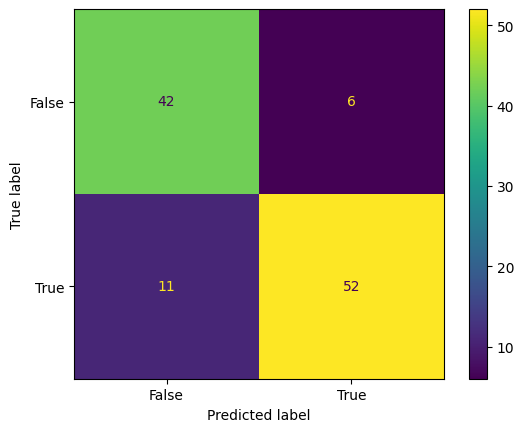

In [37]:
from sklearn import metrics

confusion_matrix = metrics.confusion_matrix(y_test,y_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()

In [38]:
TN = confusion_matrix[0][0]
FN = confusion_matrix[1][0]
TP = confusion_matrix[1][1]
FP = confusion_matrix[0][1]

In [39]:
print('Precision: %.3f' % metrics.precision_score(y_test, y_pred))
print('Recall: %.3f' % metrics.recall_score(y_test, y_pred))
print('F1 Score: %.3f' % metrics.f1_score(y_test, y_pred))

Precision: 0.897
Recall: 0.825
F1 Score: 0.860


In [40]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [41]:
y_test

array([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       0])

In [ ]:
pip install dicom